In [61]:
import numpy as np
import pandas as pd
import os
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm
import matplotlib.pyplot as plt
import collections

pd.set_option("display.max_column", 999)
print(os.listdir("../input"))

['MNCAATourneyDetailedResults.csv', 'MNCAATourneyCompactResults.csv', 'MSeasons.csv', 'MRegularSeasonDetailedResults.csv', 'MNCAATourneySlots.csv', 'MGameCities.csv', 'MConferenceTourneyGames.csv', 'Cities.csv', 'MRegularSeasonCompactResults.csv', 'MNCAATourneySeedRoundSlots.csv', 'MSampleSubmissionStage1.csv', 'MTeamConferences.csv', 'MTeamCoaches.csv', 'MMasseyOrdinals.csv', 'Conferences.csv', 'MTeams.csv', 'MNCAATourneySeeds.csv', 'MSecondaryTourneyTeams.csv', 'MTeamSpellings.csv', 'MSecondaryTourneyCompactResults.csv']


In [2]:
pip install statsmodels

     |████████████████████████████████| 9.5 MB 23 kB/s eta 0:00:010
     |████████████████████████████████| 231 kB 47 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


# Load the data!

In [78]:
tourney_results = pd.read_csv('../input/MNCAATourneyDetailedResults.csv')
seeds = pd.read_csv('../input/MNCAATourneySeeds.csv')
regular_results = pd.read_csv('../input/MRegularSeasonDetailedResults.csv')

In [79]:
tourney_results.shape

(1115, 34)

In [80]:
seeds.shape

(2286, 3)

In [81]:
regular_results.shape

(92832, 34)

In [82]:
regular_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14


In [83]:
regular_results.groupby('Season').mean()

,DayNum,WTeamID,WScore,LTeamID,LScore,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
Season,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2003,74.808709,1285.591854,75.795061,1281.750867,63.756932,0.061308,26.299393,55.367851,6.695624,17.377166,16.500650,23.250217,11.580589,25.143847,15.278380,14.211872,7.622184,3.756282,17.880633,22.869584,56.866118,5.824090,18.720971,12.193674,18.055243,11.913345,21.115901,11.877816,15.602903,6.507582,2.768198,20.413128
2004,75.335156,1285.931306,74.971122,1280.900678,62.990155,0.071319,25.928681,55.069350,6.708160,17.570335,16.405601,23.286371,11.608182,25.049880,15.137169,14.049880,7.742070,3.639029,17.798075,22.569241,56.301247,5.826515,18.825202,12.025159,18.057755,11.844235,21.224021,11.870269,15.654999,6.493984,2.741413,20.322468
2005,75.042567,1286.067166,74.693690,1282.088770,62.635294,0.066524,25.975187,54.949305,6.769840,17.678503,15.973476,22.787594,11.565775,24.964920,15.184385,13.907380,7.699251,3.730053,17.403850,22.427594,56.047914,5.904385,18.922139,11.875722,17.767059,11.733690,21.038717,11.771551,15.490481,6.509733,2.806203,19.884492
2006,74.712634,1283.769182,74.587555,1285.425478,62.666597,0.073996,25.920538,54.881228,6.845281,17.821526,15.901198,22.458272,11.591760,24.641581,15.141896,13.893000,7.616985,3.708430,17.253731,22.456801,55.836872,5.945133,18.882279,11.807862,17.589027,11.762035,20.874711,11.833929,15.521127,6.368089,2.836872,19.679210
2007,71.676780,1286.476700,74.829467,1283.896887,62.761650,0.067618,25.896887,54.196907,7.043228,18.138608,15.992465,22.698989,11.222487,24.756098,15.043030,13.909974,7.179853,3.735277,17.443783,22.419790,55.712274,6.059092,19.453500,11.862978,17.645251,11.534404,20.671227,11.667460,15.218917,6.225858,2.760658,19.985524
2008,68.392020,1288.741817,74.962425,1281.907418,62.755375,0.072439,25.932597,54.543289,7.162309,18.386791,15.934922,22.575828,11.133256,25.101491,14.921557,13.720705,7.300213,3.777455,17.450126,22.392408,55.829556,6.165408,19.622119,11.805152,17.567306,11.340306,21.026148,11.578346,15.173155,6.171025,2.836529,19.803021
2009,70.963612,1287.680511,74.033721,1281.312250,61.980377,0.071633,25.724138,54.550200,6.749095,17.743189,15.836350,22.485616,11.178129,25.155839,14.568108,13.223852,7.161174,3.723757,17.297390,22.168223,55.771004,5.759954,18.787579,11.883978,17.740331,11.440846,21.195847,11.328062,14.696895,6.093161,2.777481,19.574776
2010,70.741212,1289.607638,74.652480,1279.997910,62.484325,0.063272,25.799734,54.756603,6.655330,17.520616,16.397682,23.306289,11.247767,25.550447,14.509215,13.117234,7.100513,3.989550,17.484515,22.180885,56.121414,5.690291,18.618659,12.432263,18.563177,11.568687,21.415162,11.194376,14.431693,6.137374,2.888087,19.872126
2011,70.881243,1285.244758,74.374190,1283.078727,62.470644,0.077964,25.600839,54.468547,6.733321,17.675562,16.439192,23.221883,11.132863,25.473504,14.476363,12.904117,6.787266,3.829966,17.581395,22.159360,55.676325,5.736561,18.551658,12.415364,18.471979,11.168319,21.326916,11.180518,14.131910,5.933283,2.961685,20.081395


In [84]:
tourney_results.groupby('Season').mean()

,DayNum,WTeamID,WScore,LTeamID,LScore,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
Season,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2003,139.156250,1283.343750,76.562500,1288.765625,65.546875,0.093750,27.703125,57.906250,6.640625,16.281250,14.515625,20.218750,11.781250,25.546875,14.765625,12.875000,7.015625,3.890625,17.453125,23.375000,58.906250,6.515625,19.968750,12.281250,17.796875,12.421875,21.171875,12.031250,13.828125,6.062500,3.281250,18.875000
2004,139.156250,1286.515625,75.500000,1300.640625,64.265625,0.046875,25.890625,54.531250,6.906250,17.500000,16.812500,23.296875,11.125000,25.875000,14.859375,12.546875,6.921875,3.625000,16.625000,23.140625,58.468750,6.203125,20.468750,11.781250,16.750000,11.734375,20.593750,12.296875,12.734375,6.015625,2.031250,19.843750
2005,139.156250,1306.031250,75.562500,1299.562500,65.375000,0.109375,26.281250,54.609375,6.953125,18.015625,16.046875,22.203125,10.609375,25.203125,15.093750,13.078125,7.031250,3.484375,17.000000,23.531250,58.546875,6.328125,19.734375,11.984375,17.234375,12.359375,20.984375,12.265625,13.687500,6.781250,2.343750,19.468750
2006,139.156250,1282.250000,73.203125,1291.500000,63.171875,0.109375,24.984375,54.093750,6.609375,18.015625,16.625000,22.640625,11.109375,24.718750,14.125000,11.906250,6.718750,4.250000,15.562500,22.984375,57.234375,6.171875,19.890625,11.031250,15.625000,11.859375,21.375000,12.187500,13.375000,6.171875,3.171875,19.406250
2007,139.156250,1320.593750,75.703125,1299.421875,63.578125,0.093750,25.515625,54.250000,7.421875,18.406250,17.250000,23.531250,11.531250,25.500000,13.921875,12.265625,6.156250,4.015625,16.796875,22.937500,57.390625,6.046875,19.984375,11.656250,16.875000,11.359375,20.406250,11.500000,12.468750,5.906250,2.843750,20.328125
2008,139.156250,1329.781250,77.218750,1292.046875,63.281250,0.093750,27.500000,55.453125,6.937500,17.375000,15.281250,21.265625,11.312500,26.546875,15.218750,12.718750,6.515625,4.062500,17.468750,22.375000,57.390625,6.250000,20.609375,12.281250,18.171875,11.578125,20.031250,10.890625,12.593750,6.171875,2.890625,19.093750
2009,139.156250,1300.187500,77.250000,1284.843750,64.343750,0.046875,27.062500,57.000000,6.453125,17.265625,16.671875,23.000000,11.812500,26.531250,15.546875,12.250000,6.796875,3.687500,16.453125,23.296875,59.328125,5.968750,20.250000,11.781250,16.953125,11.734375,21.109375,11.703125,12.593750,5.953125,3.234375,19.593750
2010,139.156250,1287.031250,74.031250,1313.937500,63.328125,0.109375,25.515625,55.218750,7.125000,18.609375,15.875000,22.015625,11.546875,25.359375,14.234375,11.750000,6.875000,4.109375,17.031250,22.687500,57.484375,5.937500,19.468750,12.015625,18.109375,12.062500,21.140625,11.421875,12.234375,6.140625,3.000000,19.125000
2011,138.955224,1270.089552,73.194030,1299.208955,61.910448,0.089552,25.537313,54.716418,7.179104,18.358209,14.940299,20.223881,10.716418,25.776119,14.895522,11.059701,5.805970,3.641791,15.865672,22.313433,56.567164,5.955224,19.805970,11.328358,16.089552,10.805970,21.492537,11.447761,11.656716,5.701493,2.820896,18.313433


In [85]:
seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [86]:
tourney_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,11,29,17,26,14,30,17,12,5,3,22,29,67,12,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,7,23,11,14,11,36,22,16,10,7,8,20,64,4,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,6,14,16,22,10,27,18,9,7,4,19,25,69,7,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,3,7,18,25,11,20,15,18,13,1,19,27,60,7,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,7,20,15,23,18,20,17,13,8,2,14,25,56,9,21,15,20,10,26,16,14,5,8,19


In [87]:
all(regular_results.columns == tourney_results.columns)

True

# Data preparation!

In [88]:
regular_results.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'],
      dtype='object')

In [89]:
regular_results_swap = regular_results[[
    'Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

In [90]:
regular_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14


In [91]:
regular_results_swap.head()

,Season,DayNum,LTeamID,LScore,WTeamID,WScore,WLoc,NumOT,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF
0,2003,10,1328,62,1104,68,N,0,22,53,2,10,16,22,10,22,8,18,9,2,20,27,58,3,14,11,18,14,24,13,23,7,1,22
1,2003,10,1393,63,1272,70,N,0,24,67,6,24,9,20,20,25,7,12,8,6,16,26,62,8,20,10,19,15,28,16,13,4,4,18
2,2003,11,1437,61,1266,73,N,0,22,73,3,26,14,23,31,22,9,12,2,5,23,24,58,8,18,17,29,17,26,15,10,5,2,25
3,2003,11,1457,50,1296,56,N,0,18,49,6,22,8,15,17,20,9,19,4,3,23,18,38,3,9,17,31,6,19,11,12,14,2,18
4,2003,11,1208,71,1400,77,N,0,24,62,6,16,17,27,21,15,12,10,7,1,14,30,61,6,14,11,13,17,22,12,14,4,4,20


In [92]:
regular_results_swap.loc[regular_results['WLoc'] == 'H', 'WLoc'] = 'A'
regular_results_swap.loc[regular_results['WLoc'] == 'A', 'WLoc'] = 'H'
regular_results.columns.values[6] = 'location'
regular_results_swap.columns.values[6] = 'location'

In [93]:
regular_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,location,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14


In [94]:
regular_results_swap.head()

,Season,DayNum,LTeamID,LScore,WTeamID,WScore,location,NumOT,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF
0,2003,10,1328,62,1104,68,N,0,22,53,2,10,16,22,10,22,8,18,9,2,20,27,58,3,14,11,18,14,24,13,23,7,1,22
1,2003,10,1393,63,1272,70,N,0,24,67,6,24,9,20,20,25,7,12,8,6,16,26,62,8,20,10,19,15,28,16,13,4,4,18
2,2003,11,1437,61,1266,73,N,0,22,73,3,26,14,23,31,22,9,12,2,5,23,24,58,8,18,17,29,17,26,15,10,5,2,25
3,2003,11,1457,50,1296,56,N,0,18,49,6,22,8,15,17,20,9,19,4,3,23,18,38,3,9,17,31,6,19,11,12,14,2,18
4,2003,11,1208,71,1400,77,N,0,24,62,6,16,17,27,21,15,12,10,7,1,14,30,61,6,14,11,13,17,22,12,14,4,4,20


In [95]:
regular_results.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(regular_results.columns)]
regular_results_swap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(regular_results.columns)]

In [96]:
regular_results.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14


In [97]:
regular_results_swap.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF
0,2003,10,1328,62,1104,68,N,0,22,53,2,10,16,22,10,22,8,18,9,2,20,27,58,3,14,11,18,14,24,13,23,7,1,22
1,2003,10,1393,63,1272,70,N,0,24,67,6,24,9,20,20,25,7,12,8,6,16,26,62,8,20,10,19,15,28,16,13,4,4,18
2,2003,11,1437,61,1266,73,N,0,22,73,3,26,14,23,31,22,9,12,2,5,23,24,58,8,18,17,29,17,26,15,10,5,2,25
3,2003,11,1457,50,1296,56,N,0,18,49,6,22,8,15,17,20,9,19,4,3,23,18,38,3,9,17,31,6,19,11,12,14,2,18
4,2003,11,1208,71,1400,77,N,0,24,62,6,16,17,27,21,15,12,10,7,1,14,30,61,6,14,11,13,17,22,12,14,4,4,20


In [98]:
regular_data = pd.concat([regular_results, regular_results_swap]).sort_index().reset_index(drop = True)

In [99]:
regular_data.head(10)

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1328,62,1104,68,N,0,22,53,2,10,16,22,10,22,8,18,9,2,20,27,58,3,14,11,18,14,24,13,23,7,1,22
2,2003,10,1393,63,1272,70,N,0,24,67,6,24,9,20,20,25,7,12,8,6,16,26,62,8,20,10,19,15,28,16,13,4,4,18
3,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
4,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
5,2003,11,1437,61,1266,73,N,0,22,73,3,26,14,23,31,22,9,12,2,5,23,24,58,8,18,17,29,17,26,15,10,5,2,25
6,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
7,2003,11,1457,50,1296,56,N,0,18,49,6,22,8,15,17,20,9,19,4,3,23,18,38,3,9,17,31,6,19,11,12,14,2,18
8,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14
9,2003,11,1208,71,1400,77,N,0,24,62,6,16,17,27,21,15,12,10,7,1,14,30,61,6,14,11,13,17,22,12,14,4,4,20


In [100]:
tourney_results = pd.read_csv('../input/MNCAATourneyDetailedResults.csv')
seeds = pd.read_csv('../input/MNCAATourneySeeds.csv')
regular_results = pd.read_csv('../input/MRegularSeasonDetailedResults.csv')

def prepare_data(df):
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'    
      
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    
    return output

In [101]:
regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)

In [102]:
regular_data.shape

(185664, 35)

In [103]:
tourney_data.shape

(2230, 35)

In [104]:
regular_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
0,2003,10,1104,68,1328,62,0,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,6
1,2003,10,1272,70,1393,63,0,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16,7
2,2003,11,1266,73,1437,61,0,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23,12
3,2003,11,1296,56,1457,50,0,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23,6
4,2003,11,1400,77,1208,71,0,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14,6


In [105]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
0,2003,134,1421,92,1411,84,0,1,32,69,11,29,17,26,14,30,17,12,5,3,22,29,67,12,31,14,31,17,28,16,15,5,0,22,8
1,2003,136,1112,80,1436,51,0,0,31,66,7,23,11,14,11,36,22,16,10,7,8,20,64,4,16,7,7,8,26,12,17,10,3,15,29
2,2003,136,1113,84,1272,71,0,0,31,59,6,14,16,22,10,27,18,9,7,4,19,25,69,7,28,14,21,20,22,11,12,2,5,18,13
3,2003,136,1141,79,1166,73,0,0,29,53,3,7,18,25,11,20,15,18,13,1,19,27,60,7,17,12,17,14,17,20,21,6,6,21,6
4,2003,136,1143,76,1301,74,0,1,27,64,7,20,15,23,18,20,17,13,8,2,14,25,56,9,21,15,20,10,26,16,14,5,8,19,2


# Feature engineering!

In [106]:
tourney_data.columns

Index(['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score',
       'location', 'NumOT', 'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM',
       'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk',
       'T1_PF', 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA',
       'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF',
       'PointDiff'],
      dtype='object')

In [107]:
boxscore_cols = ['T1_Score', 'T2_Score', 
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM', 'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA', 'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF', 
        'PointDiff']

boxscore_cols = [
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
        'PointDiff']

funcs = [np.mean]

In [108]:
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs)
season_statistics.head()

T1_FGM     T1_FGA   T1_FGM3    T1_FGA3      T1_OR  \
                       mean       mean      mean       mean       mean   
Season T1_TeamID                                                         
2003   1102       19.142857  39.785714  7.821429  20.821429   4.178571   
       1103       27.148148  55.851852  5.444444  16.074074   9.777778   
       1104       24.035714  57.178571  6.357143  19.857143  13.571429   
       1105       24.384615  61.615385  7.576923  20.769231  13.500000   
       1106       23.428571  55.285714  6.107143  17.642857  12.285714   

                     T1_Ast      T1_TO    T1_Stl      T1_PF     T2_FGM  \
                       mean       mean      mean       mean       mean   
Season T1_TeamID                                                         
2003   1102       13.000000  11.428571  5.964286  18.750000  19.285714   
       1103       15.222222  12.629630  7.259259  19.851852  27.777778   
       1104       12.107143  13.285714  6.607143  18.035714  23.250000   
       1105       14.538462  18.653846  9.307692  20.230769  27.000000   
       1106       11.678571  17.035714  8.357143  18.178571  21.714286   

                     T2_FGA   T2_FGM3    T2_FGA3      T2_OR     T2_Ast  \
                       mean      mean       mean       mean       mean   
Season T1_TeamID                                                         
2003   1102       42.428571  4.750000  12.428571   9.607143   9.142857   
       1103       57.000000  6.666667  18.370370  12.037037  15.481481   
       1104       55.500000  6.357143  19.142857  10.892857  11.678571   
       1105       58.961538  6.269231  17.538462  13.192308  15.807692   
       1106       53.392857  4.785714  15.214286  11.321429  11.785714   

                      T2_TO    T2_Stl    T2_Blk PointDiff  
                       mean      mean      mean      mean  
Season T1_TeamID                                           
2003   1102       12.964286  5.428571  1.571429  0.250000  
       1103       15.333333  6.407407  2.851852  0.629630  
       1104       13.857143  5.535714  3.178571  4.285714  
       1105       18.807692  9.384615  4.192308 -4.884615  
       1106       15.071429  8.785714  3.178571 -0.142857

In [109]:
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()
season_statistics.head()

,Season,T1_TeamID,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_OR,T1_Ast,T1_TO,T1_Stl,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_OR,T2_Ast,T2_TO,T2_Stl,T2_Blk,PointDiff
,,,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,20.230769,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,18.178571,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [110]:
season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]
season_statistics.head()

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,20.230769,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,18.178571,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [111]:
season_statistics_T1 = season_statistics.copy()
season_statistics_T2 = season_statistics.copy()

season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"

In [112]:
season_statistics_T1.head()

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,20.230769,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,18.178571,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [113]:
season_statistics_T2.head()

,Season,T2_TeamID,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,20.230769,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,18.178571,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [114]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
0,2003,134,1421,92,1411,84,0,1,32,69,11,29,17,26,14,30,17,12,5,3,22,29,67,12,31,14,31,17,28,16,15,5,0,22,8
1,2003,136,1112,80,1436,51,0,0,31,66,7,23,11,14,11,36,22,16,10,7,8,20,64,4,16,7,7,8,26,12,17,10,3,15,29
2,2003,136,1113,84,1272,71,0,0,31,59,6,14,16,22,10,27,18,9,7,4,19,25,69,7,28,14,21,20,22,11,12,2,5,18,13
3,2003,136,1141,79,1166,73,0,0,29,53,3,7,18,25,11,20,15,18,13,1,19,27,60,7,17,12,17,14,17,20,21,6,6,21,6
4,2003,136,1143,76,1301,74,0,1,27,64,7,20,15,23,18,20,17,13,8,2,14,25,56,9,21,15,20,10,26,16,14,5,8,19,2


In [115]:
tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score
0,2003,134,1421,92,1411,84
1,2003,136,1112,80,1436,51
2,2003,136,1113,84,1272,71
3,2003,136,1141,79,1166,73
4,2003,136,1143,76,1301,74


In [116]:
tourney_data = pd.merge(tourney_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [117]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,12.275862,13.034483,16.206897,7.068966,19.103448,27.793103,60.965517,7.620690,20.758621,13.724138,15.862069,12.827586,8.827586,4.241379,-7.241379,24.733333,55.266667,5.933333,18.500000,13.166667,14.200000,15.233333,6.433333,18.300000,25.666667,60.400000,7.533333,23.166667,11.933333,13.766667,14.333333,8.000000,2.600000,1.966667
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,15.178571,17.642857,14.785714,8.464286,17.750000,26.357143,64.678571,6.321429,19.964286,13.107143,15.464286,16.857143,5.964286,2.392857,14.964286,24.827586,55.862069,5.275862,15.482759,12.965517,14.206897,14.068966,6.862069,15.896552,22.758621,55.068966,7.068966,21.448276,9.586207,13.275862,13.000000,7.103448,3.655172,4.655172
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,13.689655,15.551724,14.000000,5.206897,19.413793,24.793103,55.655172,5.448276,15.896552,11.000000,14.068966,15.517241,6.000000,3.931034,6.793103,26.275862,60.000000,7.000000,20.068966,14.068966,16.620690,13.793103,7.379310,18.758621,23.275862,57.862069,5.896552,18.310345,12.344828,13.310345,15.068966,7.275862,3.172414,8.689655
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,10.586207,15.620690,18.241379,7.103448,20.965517,26.344828,57.931034,4.965517,13.896552,12.241379,11.793103,16.068966,8.448276,2.482759,6.103448,28.696970,57.454545,7.969697,20.484848,10.878788,16.818182,13.363636,8.393939,17.272727,23.878788,55.333333,4.878788,14.303030,11.060606,12.363636,17.060606,6.333333,2.575758,14.909091
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,11.241379,16.000000,14.172414,6.551724,17.103448,25.379310,58.793103,7.103448,21.448276,11.172414,16.034483,14.931034,5.931034,2.517241,4.724138,24.333333,53.333333,7.966667,22.500000,9.733333,14.666667,14.200000,7.766667,18.666667,23.433333,53.133333,5.733333,17.000000,10.533333,12.566667,14.633333,7.433333,2.833333,4.400000


In [118]:
last14days_stats_T1 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T1['win'] = np.where(last14days_stats_T1['PointDiff']>0,1,0)
last14days_stats_T1 = last14days_stats_T1.groupby(['Season','T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_14d')

last14days_stats_T2 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T2['win'] = np.where(last14days_stats_T2['PointDiff']<0,1,0)
last14days_stats_T2 = last14days_stats_T2.groupby(['Season','T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_14d')

In [119]:
tourney_data = pd.merge(tourney_data, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [120]:
regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
regular_season_effects.shape

(9914, 5)

In [121]:
def team_quality(season):
    formula = 'win~-1+T1_TeamID+T2_TeamID'
    glm = sm.GLM.from_formula(formula=formula, 
                              data=regular_season_effects.loc[regular_season_effects.Season==season,:], 
                              family=sm.families.Binomial()).fit()
    
    quality = pd.DataFrame(glm.params).reset_index()
    quality.columns = ['TeamID','quality']
    quality['Season'] = season
    quality['quality'] = np.exp(quality['quality'])
    quality = quality.loc[quality.TeamID.str.contains('T1_')].reset_index(drop=True)
    quality['TeamID'] = quality['TeamID'].apply(lambda x: x[10:14]).astype(int)
    return quality

In [122]:
glm_quality = pd.concat([team_quality(2010),
                         team_quality(2011),
                         team_quality(2012),
                         team_quality(2013),
                         team_quality(2014),
                         team_quality(2015),
                         team_quality(2016),
                         team_quality(2017),
                         team_quality(2018)]).reset_index(drop=True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:188: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [123]:
glm_quality_T1 = glm_quality.copy()
glm_quality_T2 = glm_quality.copy()
glm_quality_T1.columns = ['T1_TeamID','T1_quality','Season']
glm_quality_T2.columns = ['T2_TeamID','T2_quality','Season']

In [124]:
tourney_data = pd.merge(tourney_data, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [125]:
seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [126]:
seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
seeds.head()

,Season,Seed,TeamID,seed
0,1985,W01,1207,1
1,1985,W02,1210,2
2,1985,W03,1228,3
3,1985,W04,1260,4
4,1985,W05,1374,5


In [127]:
seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']

In [128]:
tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [129]:
tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]

In [130]:
tourney_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_quality,T2_quality,T1_seed,T2_seed,Seed_diff
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,12.275862,13.034483,16.206897,7.068966,19.103448,27.793103,60.965517,7.620690,20.758621,13.724138,15.862069,12.827586,8.827586,4.241379,-7.241379,24.733333,55.266667,5.933333,18.500000,13.166667,14.200000,15.233333,6.433333,18.300000,25.666667,60.400000,7.533333,23.166667,11.933333,13.766667,14.333333,8.000000,2.600000,1.966667,1.000000,0.833333,NaN,NaN,16,16,0
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,15.178571,17.642857,14.785714,8.464286,17.750000,26.357143,64.678571,6.321429,19.964286,13.107143,15.464286,16.857143,5.964286,2.392857,14.964286,24.827586,55.862069,5.275862,15.482759,12.965517,14.206897,14.068966,6.862069,15.896552,22.758621,55.068966,7.068966,21.448276,9.586207,13.275862,13.000000,7.103448,3.655172,4.655172,0.666667,1.000000,NaN,NaN,1,16,-15
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,13.689655,15.551724,14.000000,5.206897,19.413793,24.793103,55.655172,5.448276,15.896552,11.000000,14.068966,15.517241,6.000000,3.931034,6.793103,26.275862,60.000000,7.000000,20.068966,14.068966,16.620690,13.793103,7.379310,18.758621,23.275862,57.862069,5.896552,18.310345,12.344828,13.310345,15.068966,7.275862,3.172414,8.689655,0.666667,0.750000,NaN,NaN,10,7,3
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,10.586207,15.620690,18.241379,7.103448,20.965517,26.344828,57.931034,4.965517,13.896552,12.241379,11.793103,16.068966,8.448276,2.482759,6.103448,28.696970,57.454545,7.969697,20.484848,10.878788,16.818182,13.363636,8.393939,17.272727,23.878788,55.333333,4.878788,14.303030,11.060606,12.363636,17.060606,6.333333,2.575758,14.909091,1.000000,1.000000,NaN,NaN,11,6,5
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,11.241379,16.000000,14.172414,6.551724,17.103448,25.379310,58.793103,7.103448,21.448276,11.172414,16.034483,14.931034,5.931034,2.517241,4.724138,24.333333,53.333333,7.966667,22.500000,9.733333,14.666667,14.200000,7.766667,18.666667,23.433333,53.133333,5.733333,17.000000,10.533333,12.566667,14.633333,7.433333,2.833333,4.400000,0.333333,0.600000,NaN,NaN,8,9,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2225,2019,146,1246,71,1120,77,26.606061,55.606061,6.030303,16.575758,11.606061,13.848485,12.636364,6.030303,16.303030,23.303030,57.787879,7.757576,22.151515,9.333333,11.242424,12.545455,5.666667,3.000000,11.303030,27.029412,60.441176,11.411765,29.970588,11.735294,14.411765,12.147059,9.294118,18.382353,23.235294,52.941176,8.323529,23.382353,10.764706,12.029412,17.588235,5.911765,3.676471,10.294118,0.750000,1.000000,NaN,NaN,2,5,-3
2226,2019,146,1181,67,1277,68,30.500000,63.911765,7.264706,24.058824,13.382353,15.911765,13.117647,9.470588,15.852941,25.235294,63.852941,6.500000,22.117647,11.970588,12.294118,14.764706,6.529412,3.176471,15.941176,27.764706,57.176471,8.294118,21.617647,10.823529,18.941176,12.852941,5.235294,16.911765,23.323529,61.705882,7.264706,22.852941,11.029412,12.382353,10.264706,6.411765,2.941176,13.294118,0.800000,1.000000,NaN,NaN,1,2,-1
2227,2019,152,1277,51,1403,61,27.764706,57.176471,8.29411

In [131]:
season_statistics

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,20.230769,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,18.178571,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6182,2020,1463,26.392857,57.285714,8.892857,24.071429,8.607143,14.857143,13.000000,6.214286,15.035714,23.964286,59.392857,7.285714,23.821429,7.964286,12.071429,11.678571,6.785714,3.142857,8.142857
6183,2020,1464,25.580645,61.548387,7.193548,23.064516,13.709677,11.967742,12.225806,5.322581,17.806452,26.193548,59.129032,6.838710,19.935484,10.483871,12.838710,11.387097,5.838710,3.387097,-0.774194
6184,2020,1465,25.296296,58.925926,9.259259,24.555556,11.037037,12.777778,12.518519,3.592593,18.296296,26.370370,61.481481,5.814815,19.148148,9.777778,12.555556,9.888889,6.037037,3.740741,4.666667
6185,2020,1466,22.892857,54.678571,6.642857,19.821429,9.785714,10.392857,15.035714,6.142857,20.214286,24.321429,55.035714,6.357143,18.785714,9.178571,10.500000,13.571429,5.607143,3.857143,-3.178571


# Time to build some models!

In [132]:
y = tourney_data['T1_Score'] - tourney_data['T2_Score']
y.describe()

count    2230.000000
mean        0.000000
std        14.342819
min       -56.000000
25%       -10.000000
50%         0.000000
75%        10.000000
max        56.000000
dtype: float64

In [133]:
features = list(season_statistics_T1.columns[2:999]) + \
    list(season_statistics_T2.columns[2:999]) + \
    list(seeds_T1.columns[2:999]) + \
    list(seeds_T2.columns[2:999]) + \
    list(last14days_stats_T1.columns[2:999]) + \
    list(last14days_stats_T2.columns[2:999]) + \
    ["Seed_diff"] + ["T1_quality","T2_quality"]

len(features)

45

In [134]:
X = tourney_data[features].values
dtrain = xgb.DMatrix(X, label = y)

In [135]:
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess

In [136]:
param = {} 
#param['objective'] = 'reg:linear'
param['eval_metric'] =  'mae'
param['booster'] = 'gbtree'
param['eta'] = 0.05 #change to ~0.02 for final run
param['subsample'] = 0.35
param['colsample_bytree'] = 0.7
param['num_parallel_tree'] = 3 #recommend 10
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] =  3
param['silent'] = 1

print(param)

{'eval_metric': 'mae', 'booster': 'gbtree', 'eta': 0.05, 'subsample': 0.35, 'colsample_bytree': 0.7, 'num_parallel_tree': 3, 'min_child_weight': 40, 'gamma': 10, 'max_depth': 3, 'silent': 1}


In [137]:
xgb_cv = []
repeat_cv = 3 # recommend 10

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 25,
          verbose_eval = 50
        )
    )

Fold repeater 0
[12:55:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:55:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:55:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used bu

In [138]:
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
iteration_counts, val_mae

([118, 132, 107], [8.867370000000001, 8.8143998, 8.8550028])

In [139]:
oof_preds = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-30,30))

Fold repeater 0
[12:55:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:55:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:55:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used bu

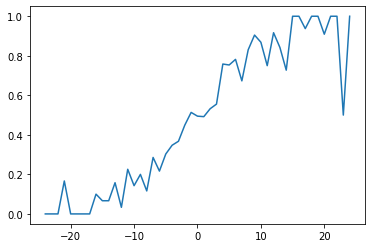

In [140]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0)})
plot_df["pred_int"] = plot_df["pred"].astype(int)
plot_df = plot_df.groupby('pred_int')['label'].mean().reset_index(name='average_win_pct')

plt.figure()
plt.plot(plot_df.pred_int,plot_df.average_win_pct)

In [141]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
        
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    
    print(f"logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

logloss of cvsplit 0: 0.5472878744471649
logloss of cvsplit 1: 0.5455993657956992
logloss of cvsplit 2: 0.5420936429120684


<ipython-input-142-3d805c66ae43>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  plot_df = plot_df.groupby('pred_int')['spline','label'].mean().reset_index()


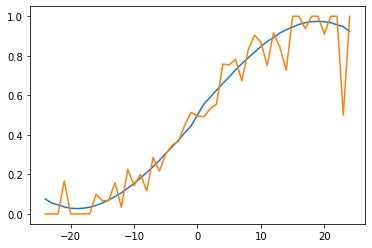

In [142]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0), "spline":spline_model[0](oof_preds[0])})
plot_df["pred_int"] = (plot_df["pred"]).astype(int)
plot_df = plot_df.groupby('pred_int')['spline','label'].mean().reset_index()

plt.figure()
plt.plot(plot_df.pred_int,plot_df.spline)
plt.plot(plot_df.pred_int,plot_df.label)

In [146]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.5472878744471649
adjusted logloss of cvsplit 1: 0.5454719120156234
adjusted logloss of cvsplit 2: 0.5421095809998595


In [147]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 1.3108522263206028
adjusted logloss of cvsplit 1: 1.3097319364929394
adjusted logloss of cvsplit 2: 1.306367143361485


In [148]:
#looking for upsets
pd.concat(
    [tourney_data[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score > tourney_data.T2_Score)]]
)   

#https://en.wikipedia.org/wiki/NCAA_Division_I_Women%27s_Basketball_Tournament_upsets

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_quality,T2_quality,T1_seed,T2_seed,Seed_diff
2129,2018,137,1438,54,1420,74,25.000000,54.181818,7.363636,18.878788,8.393939,13.727273,8.575758,6.787879,14.060606,18.818182,50.151515,6.151515,20.303030,8.393939,8.848485,12.727273,3.878788,2.636364,14.151515,25.612903,58.451613,9.838710,25.774194,9.709677,14.870968,11.677419,7.387097,16.516129,25.322581,56.612903,8.322581,23.161290,9.935484,13.580645,14.322581,6.258065,2.806452,1.516129,1.000000,1.000000,inf,0.000000e+00,1,16,-15
1720,2012,137,1181,70,1250,75,25.757576,56.272727,8.121212,21.606061,11.909091,12.454545,12.181818,6.242424,18.181818,25.515152,58.909091,4.454545,14.060606,11.696970,11.151515,12.909091,5.666667,2.666667,9.060606,25.750000,57.812500,7.406250,20.875000,10.843750,13.000000,11.531250,7.812500,17.781250,23.187500,55.562500,5.968750,17.906250,10.218750,13.062500,14.687500,5.687500,3.843750,10.218750,0.500000,1.000000,5.127021e+00,2.618287e-11,2,15,-13
1723,2012,137,1281,84,1313,86,28.000000,55.588235,8.235294,20.823529,9.176471,16.205882,10.294118,8.205882,14.117647,24.617647,55.794118,6.235294,17.205882,10.764706,12.823529,14.411765,5.264706,2.647059,14.558824,24.312500,54.281250,5.343750,17.031250,11.187500,12.000000,14.812500,6.531250,19.093750,23.375000,57.687500,5.625000,18.468750,12.281250,11.093750,13.656250,6.593750,3.125000,2.812500,1.000000,1.000000,8.116465e+00,3.852933e-11,2,15,-13
1783,2013,137,1207,68,1195,78,23.000000,50.419355,5.870968,16.419355,9.225806,14.806452,12.677419,7.548387,16.870968,19.419355,51.612903,5.354839,17.580645,10.806452,10.903226,14.225806,6.354839,3.290323,8.838710,26.218750,57.500000,6.625000,20.031250,11.687500,13.718750,14.656250,8.812500,17.593750,23.625000,57.468750,6.875000,21.843750,12.000000,13.281250,15.656250,6.937500,3.031250,5.031250,0.500000,1.000000,4.979810e+00,1.554166e+00,2,15,-13
1985,2016,137,1277,81,1292,90,28.794118,59.529412,9.117647,21.029412,12.294118,20.558824,11.794118,4.411765,19.088235,21.794118,57.823529,5.676471,18.794118,9.352941,10.617647,9.558824,5.323529,3.235294,16.382353,25.903226,57.709677,8.000000,20.580645,10.258065,13.032258,11.935484,6.258065,20.451613,23.225806,54.322581,6.258065,18.354839,9.064516,11.451613,13.516129,5.838710,2.774194,4.096774,1.000000,1.000000,3.995089e+00,2.796520e-20,2,15,-13
1260,2005,137,1242,63,1137,64,26.931034,56.482759,6.793103,18.206897,11.793103,16.586207,14.482759,6.620690,19.241379,22.103448,57.137931,6.275862,19.517241,13.000000,10.655172,14.103448,7.103448,2.827586,10.206897,21.258065,47.741935,6.612903,17.580645,9.354839,12.451613,15.774194,8.000000,18.870968,19.580645,50.290323,6.000000,18.322581,10.967742,10.451613,15.870968,7.032258,2.516129,5.129032,0.500000,1.000000,NaN,NaN,3,14,-11
1334,2006,137,1234,63,1322,64,23.121212,53.636364,5.606061,16.727273,11.000000,14.909091,14.757576,6.696970,15.121212,21.484848,56.484848,6.090909,19.333333,11.181818,12.484848,14.787879,7.515152,2.969697,7.636364,26.620690,57.344828,6.586207,18.137931,13.068966,16.655172,15.793103,8.827586,20.896552,24.172414,55.517241,5.655172,16.482759,13.000000,13.965517,17.310345,7.379310,2.862069,6.172414,1.000000,1.000000,NaN,NaN,3,14,-11
1573,2010,136,1207,83,1325,97,26.484848,53.151515,6.181818,15.939394,9.666667,15.454545,13.787879,7.030303,16.909091,22.909091,55.606061,6.151515,18.878788,11.272727,13.0

In [149]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.5226746172818852
adjusted logloss of cvsplit 1: 0.5211690660958503
adjusted logloss of cvsplit 2: 0.518706261557013


In [150]:
val_cv = []
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    val_cv.append(pd.DataFrame({"y":np.where(y>0,1,0), "pred":spline_fit, "season":tourney_data.Season}))
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 
    
val_cv = pd.concat(val_cv)
val_cv.groupby('season').apply(lambda x: log_loss(x.y, x.pred))

adjusted logloss of cvsplit 0: 0.5226746172818852
adjusted logloss of cvsplit 1: 0.5211690660958503
adjusted logloss of cvsplit 2: 0.518706261557013


season
2003    0.525104
2004    0.485911
2005    0.482845
2006    0.548997
2007    0.421041
2008    0.455658
2009    0.459591
2010    0.550272
2011    0.582773
2012    0.557609
2013    0.578002
2014    0.586339
2015    0.509914
2016    0.544544
2017    0.494169
2018    0.576926
2019    0.484126
dtype: float64

# Submission time!

In [151]:
sub = pd.read_csv('../input/WSampleSubmissionStage2.csv')
sub.head()

FileNotFoundError: [Errno 2] No such file or directory: '../input/WSampleSubmissionStage2.csv'

In [ ]:
sub["Season"] = 2018
sub["T1_TeamID"] = sub["ID"].apply(lambda x: x[5:9]).astype(int)
sub["T2_TeamID"] = sub["ID"].apply(lambda x: x[10:14]).astype(int)
sub.head()

In [ ]:
sub = pd.merge(sub, season_statistics_T1, on = ['Season', 'T1_TeamID'])
sub = pd.merge(sub, season_statistics_T2, on = ['Season', 'T2_TeamID'])
sub = pd.merge(sub, glm_quality_T1, on = ['Season', 'T1_TeamID'])
sub = pd.merge(sub, glm_quality_T2, on = ['Season', 'T2_TeamID'])
sub = pd.merge(sub, seeds_T1, on = ['Season', 'T1_TeamID'])
sub = pd.merge(sub, seeds_T2, on = ['Season', 'T2_TeamID'])
sub = pd.merge(sub, last14days_stats_T1, on = ['Season', 'T1_TeamID'])
sub = pd.merge(sub, last14days_stats_T2, on = ['Season', 'T2_TeamID'])
sub["Seed_diff"] = sub["T1_seed"] - sub["T2_seed"]
sub.head()

In [ ]:
Xsub = sub[features].values
dtest = xgb.DMatrix(Xsub)

In [ ]:
sub_models = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    sub_models.append(
        xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = int(iteration_counts[i] * 1.05),
          verbose_eval = 50
        )
    )

In [ ]:
sub_preds = []
for i in range(repeat_cv):
    sub_preds.append(np.clip(spline_model[i](np.clip(sub_models[i].predict(dtest),-30,30)),0.025,0.975))
    
sub["Pred"] = pd.DataFrame(sub_preds).mean(axis=0)

sub.loc[(sub.T1_seed==1) & (sub.T2_seed==16), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==2) & (sub.T2_seed==15), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==3) & (sub.T2_seed==14), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==4) & (sub.T2_seed==13), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==16) & (sub.T2_seed==1), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==15) & (sub.T2_seed==2), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==14) & (sub.T2_seed==3), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==13) & (sub.T2_seed==4), 'Pred'] = 0.0

sub[['ID','Pred']].to_csv("paris-submission.csv", index = None)

In [ ]:
tourney_results2018 = pd.read_csv('../input/NCAA_2018_Solution_Womens.csv')
tourney_results2018 = tourney_results2018[tourney_results2018.Pred!=-1].reset_index(drop=True)
tourney_results2018.columns = ['ID', 'label']
tourney_results2018 = pd.merge(tourney_results2018, sub, on = 'ID')
log_loss(tourney_results2018.label, tourney_results2018.Pred)